# MSIN0097 Predictive Analytics 

### - Individual Coursework  (2078 words including table of contents and titles)

# Table of contents

* [0 - Setting up environment](#Setupenvironment)
* [1 - Introduction and Data Overview](#introduction)
* [2 - Exploratory Analysis](#eda)
    * [2.1 Euribor 3 month and Marketing outcome](#2.1)
    * [2.2 Age, Job and Marketing outcome](#2.2)
    * [2.3 Number of contacts in a campaign & Previous Number of contacts](#2.3)
* [3 - Data cleaning & engineering](#dce)
    * [3.1 Converting the target vairable to 1 and 0](#3.1)
    * [3.2 Replacing 'unknown' with Nan](#3.2)
    * [3.3 Evaluate the number of incomplete records](#3.3)
    * [3.4 Investigate missing pattern](#3.4)
    * [3.5 Imputing missing values](#3.5)
    * [3.6 Split train test data](#3.6)
    * [3.7 Feature selection](#3.7)
    * [3.8 Re-sampling](#3.8)
* [4 - Prepare data for modeling](#preparedata)
    * [4.1 Data transformation](#4.1)
    * [4.2 Create a base model](#4.2)
* [5 - Model selection](#ms)
    * [5.1 Test model performance using 5 folds](#5.1)
    * [5.2 Plot the performances in each fold ](#5.2)
    * [5.3 Un-tunned models performance on test data](#5.3)
* [6 - Model tuning](#my)
    * [6.1 Random Forest Classifier](#6.1)
    * [6.2 XGB Classifier](#6.2)
    * [6.3 Histogram based Gradient Boosting Classifier](#6.3)
    * [6.4 Tunned models performance on test data](#6.4)
* [7 - Voting Classifiers](#voting)
    * [7.1 Hard voting using un-tunned models](#7.1)
    * [7.2 Soft voting using tunned models](#7.2)
    * [7.3 Compare final voting models' performance with base mod](#7.3)
* [8 - Summary](#summary)

# 0. Set up environment <a name="Setupenvironment"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE, ADASYN

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.metrics import fbeta_score,accuracy_score

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

# Data Dictionary 
   **Input variables:**
   
   #### bank client data:
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   #### related with the last contact of the current campaign:
   
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   #### other attributes:
  
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
   #### social and economic context attributes
  
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
 
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)


  **Output variable (desired target):**
  
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")



# 1. Introduction and Data Overview<a name="introduction"></a>

---
- **Project goal**

We wanted to use historical telemarketing data to simulate the customer's final purchase decision. The finalised model can then predict the outcome of future campaigns, allowing the salesperson to optimise the calling sequence and thus improve efficiency and the total purchase rate. The primary metrics we want to **optimize** is **accuracy and precision**. 


- **Data background**

This data is obtained from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing). A Portuguese banking institution provides this data, and it contains results of direct marketing campaigns for term deposits based on phone calls in 10 months. According to [investopedia](https://www.investopedia.com/terms/t/termdeposit.asp), a term deposit is a financial product that guarantees a fixed interest rate for your deposit. 


- **Data overview**


1. We have about >41k records in this data. 
2. 11 categorical variables and 9 numerical variables. 
3. The input variable's types are mixed, including 'age', 'contact method' etc., 
4. The target variable is a binary categorical variable -'outcome'.
5. No missing data in this dataset, but several categorical attributes have an 'unknown' category.

---

In [2]:
df_bank_raw= pd.read_csv("bank-additional-full.csv",sep = ";")
df_bank_raw.drop(columns = ['duration'], inplace = True)
df_bank_raw.rename({'y': 'outcome'}, axis=1, inplace=True)
df_bank = df_bank_raw.copy()
df_bank_raw.head(3)

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed outcome  
0          93.994          -36.4      4.857       5191.0      no  
1          93.994          -36.4      4.857       5191.0      no  
2          93.994          -36.4      4.857       5191.0      no

- No missing data

In [3]:
df_bank_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

- The value range for each column differs significantly, such as 'euribor3m' and 'nr.employed'.

In [4]:
df_bank_raw.describe()

age      campaign         pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963      0.081886   
std       10.42125      2.770014    186.910907      0.494901      1.570960   
min       17.00000      1.000000      0.000000      0.000000     -3.400000   
25%       32.00000      1.000000    999.000000      0.000000     -1.800000   
50%       38.00000      2.000000    999.000000      0.000000      1.100000   
75%       47.00000      3.000000    999.000000      0.000000      1.400000   
max       98.00000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count    41188.000000   41188.000000  41188.000000  41188.000000  
mean        93.575664     -40.502600      3.621291   5167.035911  
std          0.578840       4.628198      1.734447     72.251528  
min         92.201000     -50.800000      0.634000   4963.600000  
25%         93.075000     -42.700000      1.344000   5099.100000  
50%         93.749000     -41.800000      4.857000   5191.000000  
75%         93.994000     -36.400000      4.961000   5228.100000  
max         94.767000     -26.900000      5.045000   5228.100000

- Print out the labels for each categorical variable to see if there is any unusual category

In [5]:
def check_categorial_values(data):
    for c in data.columns:
        if data[c].dtype == 'object':
            unique_vals = data[c].unique()
            print(c,"-"*5,unique_vals)
            
check_categorial_values(df_bank)

job ----- ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital ----- ['married' 'single' 'divorced' 'unknown']
education ----- ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default ----- ['no' 'unknown' 'yes']
housing ----- ['no' 'yes' 'unknown']
loan ----- ['no' 'yes' 'unknown']
contact ----- ['telephone' 'cellular']
month ----- ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week ----- ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome ----- ['nonexistent' 'failure' 'success']
outcome ----- ['no' 'yes']


- Divide the columns into two lists based on the data type because we may need to use different methods to process these attributes later.

In [6]:
categorical_columns = []
numerical_columns = []

for c in df_bank:
    if df_bank[c].dtype == 'object':
        categorical_columns.append(c)
    else:
        numerical_columns.append(c)

print("categorical_columns - \n",categorical_columns,"\n")
print("numerical_columns - \n",numerical_columns)

categorical_columns - 
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'outcome'] 

numerical_columns - 
 ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Conclusion and decisions:

---

- The dataset is Labelled.

    We should use **supervised learning model** for this project.


- Binary categorical target variable -'outcome'.
    
    The final model type should be **classifier**.


-  This dataset contains 11 categorical columns, and each has many labels.

    [Sklearn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)'s algorithm cheatsheet suggested using Linear SVC and KNN classifier for this data. However, although SVM-based models such as linear SVC may obtain good results, running and tuning for such a model will be too time-consuming. 

    The one-hot encoded ML-ready data will have about 60 columns. Hence, we will **avoid the SVM model** in the model testing stage. 


- The value range for each column differs greatly, and some attributes have outliers. 

    Due to computation limitations, we will not use any distance-based method except for the KNN classifier just for comparison purposes. We expect to **use tree-based algorithms and boosting algorithms** for this project, which are not affected by outliers nor large values. Hence, we will **skip feature scaling and remove outliers** for later data engineering.

---

# 2. Exploratory Analysis<a name="eda"></a>

---

- We used the pandas profiling function to create plots of the distribution of each variable and some correlation matrices. 


- We will deep dive into a few exciting findings below to draw insights for modelling. 
    
---

In [7]:
#use pandas profiling to gain some basic observations
report = ProfileReport(df_bank_raw)
report.to_file(output_file='data_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
#Please see data_report.html for the full file if the output is not complete
report

### 2.1 Euribor 3 month<a name="2.1"></a>

---

In [9]:
df_eda = df_bank_raw.copy()
# Change successful to 1, unsuccessful to 0
df_eda['outcome'] = (df_eda['outcome'] == 'yes').astype(int)

In [10]:
# This is a function that computes the number and percentage of successful given a variable
def percent_table(data, column, target='outcome'):
    new_table = data.groupby(column)[target].agg({'sum','count'})
    new_table['percentage'] = new_table['sum']/new_table['count']
    return new_table

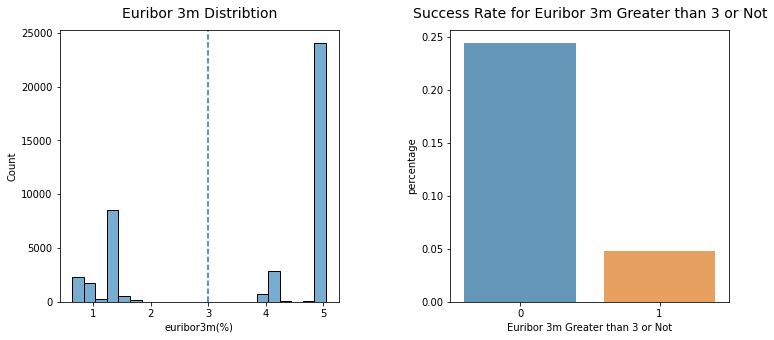

In [11]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

# Plot the Euribor 3m Distribution of our data and split it to two parts
sns.histplot(df_eda['euribor3m'],ax=ax[0], alpha = 0.6)
ax[0].set_title('Euribor 3m Distribtion', fontsize =14, pad=12)
ax[0].set_xlabel('euribor3m(%)')
ax[0].axvline(3, linestyle='--')

# Plot the percentage of Success by whether Euribor 3m greater 3 or not
df_eda['euribor3mgreater3'] = (df_eda['euribor3m'] > 3).astype(int)
sns.barplot(data=percent_table(df_eda, 'euribor3mgreater3').reset_index(),
           x='euribor3mgreater3',y='percentage', ax=ax[1], alpha = 0.75)
ax[1].set_title('Success Rate for Euribor 3m Greater than 3 or Not', fontsize =14, pad=12)
ax[1].set_xlabel('Euribor 3m Greater than 3 or Not')

plt.subplots_adjust(wspace = 0.4) # Adjust the space between plots
plt.show()

In [12]:
# provide numerical details for above plots
percent_table(df_eda, 'euribor3mgreater3').style.background_gradient()

---
### Observation:

- In the left plot -'Euribor 3 month' Distribution, we found that the values can be split into 2 groups by drawing a line at 3%. One group's values are around 1 to 2, and the other group's values are about 4 to 5. 


- In the right plot, we found that the success rate for records with an Euribor rate lower than 3% is 4 times higher than those with a Euribor rate greater than 3%. From this, we suspect that Euribor rate is an important factor when predicting success rate.


### Insights:


- From the above findings, we can conclude that the Euribor 3-month rate appears to be an important factor influencing marketing results. However, this conclusion is not certain as we are not sure of the bank's term deposit rates. The bank's interest strategy can also influence customer behaviour.

### 2.2 Age , Job , Marital status<a name="2.2"></a>

---

- From the pandas profiling report, we notice that Age, Job and Marital status are more correlated to the marketing outcome than the other.

- First, let's display the average success rate of different category group for each attributes using coloured dataframe. 

In [13]:
# provide numerical details for plots
percent_table(df_eda, 'job').style.background_gradient()

---
### Observation:

- Majority of job groups have purchase rates around **10%**, except for the **'student'** and **'retired'** groups. These two groups have **exceptionally high purchase rates** than the other groups with **31%** and **25%** respectively.

In [14]:
# provide numerical details for plots
percent_table(df_eda, 'marital').style.background_gradient()

---
### Observation:

- After dividing people into different groups by their marrital status, we found that the **'single'** and 'unknown' groups have **higher purchase rates of around 15%** than the 'divorced' and 'married' groups. 


- We will further group the marital status into 'been_married' and 'never_married' groups to explore the relation between marital status and age.

We will not discuss the 'unknown' group becasue the sample size is too small. 

In [15]:
# Partition the age to 7 different age ranges
df_eda['age_bins'] = pd.cut(x=df_eda['age'], bins=[0,20,25,30,45,55,60,120])
percent_table(df_eda, 'age_bins').style.background_gradient()

---
### Observation:

- After discreterizing the 'age' attribute into 7 age groups, we found people **under 20s** and people who are **greater than 60s** have **much higher purchase rate** of **more than 40%**.

- Although the size of the (0,20] group is much smaller than the others, but we can still see that purchase rate is **generally higher in younger groups**, and as the age goes smaller the higher the purchase rate.

---
- Next, let's visualise the inter-relationship between age, job and marital status.

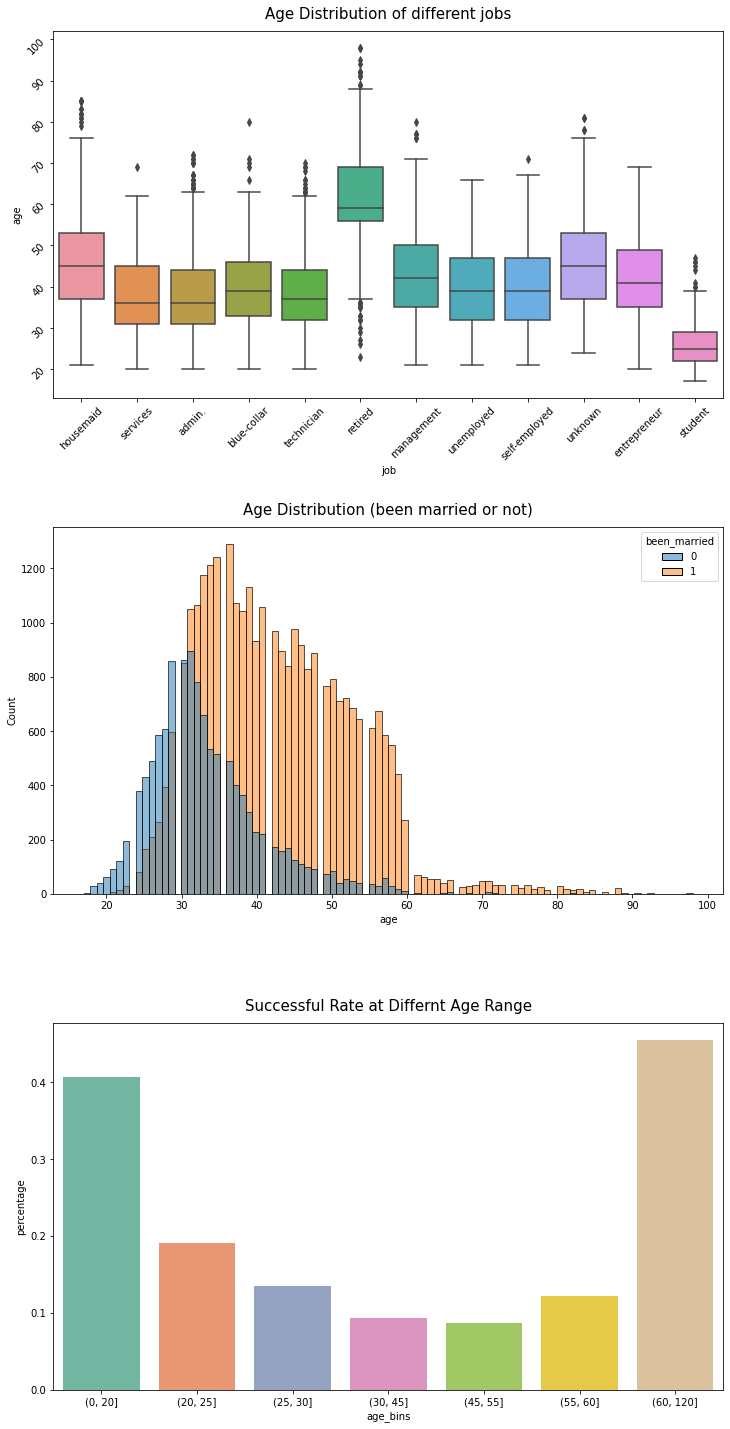

In [16]:
# Create a new variable that if this person been married before
df_eda['been_married'] = ((df_eda['marital'] == 'divorced') | (df_eda['marital'] == 'married')).astype(int)

fig,ax = plt.subplots(3,1, figsize = (12,25))
# Plot the age distribution of different jobs
sns.boxplot(data= df_eda[['age','job']],x='job',y='age',ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_title('Age Distribution of different jobs', fontsize=15, pad=12)

# Plot the age distribution of different marital status (been married or not)
sns.histplot(data=df_eda,x='age',hue = 'been_married',ax=ax[1])
ax[1].set_title('Age Distribution (been married or not)', fontsize =15, pad=12)

# Plot the successful rate for different ages
sns.barplot(x='age_bins',y='percentage',
            data = percent_table(df_eda, 'age_bins').reset_index(),
           palette = 'Set2',ax=ax[2])
ax[2].set_title('Successful Rate at Differnt Age Range', fontsize = 15, pad =12)

plt.subplots_adjust(hspace = 0.35) # Adjust the space between plots


plt.show()

---

### Observations:

- From the first plot, we observed the **'retired'** group's average age is **over 60**. **'student'** group's average age is **around 20**.


- From the second plot, we observed that the **'been_married'** group's average age is around **35**, and the **'never_married'** group's average is about **30**. 


- From the third plot, we observed that the previous findings are correlated to this graph: 

    - The real reason 'retired' and 'student' groups have a higher purchase rate is because their average age 20 and 60, each falls into the (0,20] and (60,120] age groups.
    
    - The 'never_married' and 'been_married' group has an average age of 30 and 35, respectively. And thus, the purchase rate of the **'never_married' or 'single' group (14%)** is similar to the purchase rate of the **(25,30] group (13.5%)**. The purchase rate of the **'been_married' group (10%)** is similar to that of the **(30,35] group (9%).**


### Insights:

- Before, we thought that age, job and marital status were all equally essential attributes from the correlation matrices. But after dissecting the relationships between these variables, we found that **job and marital status are only important because of their intrinsic correlation with age**. Hence, we can conclude that **age is a critical predicting factor for the model.**


### 2.3 Number of contacts in this compaign & Previous number of contacts <a name="2.3"></a>

---

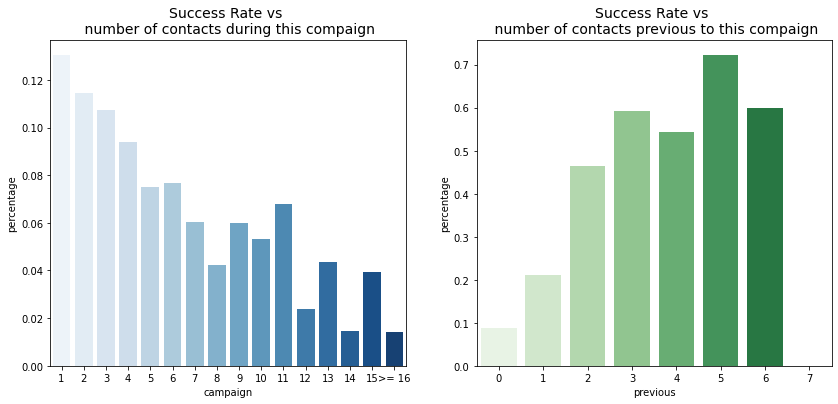

In [17]:
campaign_df = percent_table(df_eda, 'campaign')

fig,ax = plt.subplots(1,2, figsize = (14,6))
# group the data of campaign number >= 16 to a single row
campaign_df.loc[16] = campaign_df.loc[16:].sum()
campaign_df = campaign_df.loc[:16]
campaign_df['percentage'] = campaign_df['sum']/campaign_df['count']
campaign_df.rename(index={16:'>= 16'},inplace=True)

#Plot the successful rate at different number of contacts during this compaign
sns.barplot(data=campaign_df.reset_index(),x='campaign',y='percentage',
            palette='Blues',ax=ax[0])
ax[0].set_title('Success Rate vs \n number of contacts during this compaign', fontsize =14)

#Plot the successful rate at different number of contacts previous to this compaign
previous_df = percent_table(df_eda, 'previous')
sns.barplot(data=previous_df.reset_index(),x='previous',y='percentage',
            palette='Greens',ax=ax[1])
ax[1].set_title('Success Rate vs \n number of contacts previous to this compaign', fontsize =14)
plt.show()

---

### Observation:

- From the left plot, we found the number of contacts negatively correlated with the success rate. **The more marketers contact** the customer in a single campaign, **the less likely customers will buy** the term deposit product. 


- However, from the right plot, we observed that **the more contacts before the campaign**, **the more likely customers would respond** to the current campaign. 

### Insights:


- The above findings could be used to make **four suggestions** to the bank marketers: 

    1. The marketers should **prioritize the clients** they have **previously reached out to**.
    2. Start **contacting customers before the campaign** starts may help increase the success rate.
    3. The marketers should **control the number of contacts** in a single campaign as customers are more and more unlikely to buy the product. 
    4. If there is still no positive outcome from a customer who has been contacted ten times. Then, the marketer may want to move on and talk to other customers as the **success rate is halved after the 10th contact**.
    

# 3. Data cleaning & engineering<a name="dce"></a>

---

- Below, we will use 'df_bank' to demonstrate why we do each step and prove that data engineering will positively impact prediction accuracy.

- To avoid one-time codes, We will encapsulate all cleaning and engineering steps in functions so that we can reuse the functions if new data is available. 

### 3.1 Converting the target vairable to 1 and 0<a name="3.1"></a>

In [18]:
def clean_data(data):
    data["outcome"] = data["outcome"].replace({"yes":1, "no":0})
    return data

In [19]:
df_bank_raw = clean_data(df_bank_raw)
df_bank = clean_data(df_bank)

### 3.2 Replacing 'unknown' with Nan<a name="3.2"></a>
---
- Because 'unknown' is in many data entries and does not carry any information, we should replace it with nulls.

In [20]:
#replace unknown to null values
cate_cols = categorical_columns
cate_cols = cate_cols[:-1]

def clear_unknown(df):
    for c in cate_cols:
        df[c] = df[c].replace({"unknown":np.nan})
    return df

In [21]:
df_bank = clear_unknown(df_bank)

### 3.3 Evaluate the number of incomplete records <a name="3.3"></a>
---
- When assessing the missingness in data, we found that about 1/4 of the records contains at least 5% of null values. 

- Because the number of incomplete rows is significant, we cannot drop these rows straight away without knowing the pattern of missingness.

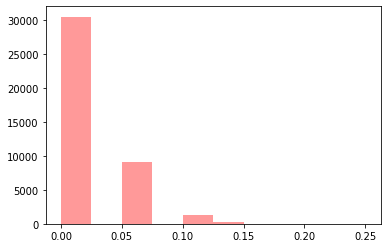

In [22]:
# How much data is missing in each row of the dataframe?
nulls_in_row = df_bank.isnull().sum(axis=1)/len(df_bank.columns)

n, bins, patches = plt.hist(nulls_in_row, 10, facecolor='red', alpha=0.4)
plt.show();

### 3.4 Investigate missing pattern<a name="3.4"></a>
---
- We noticed that most of the null values are from the 'default', 'education', 'housing' and 'loan' columns. 

- The missing values are concentrated in particular columns such as 'education'. Therefore, we can use the most common category to replace the null values and consider removing the incomplete records after analysing the importance of the attributes. 

In [23]:
# missing pattern in columns
pd.DataFrame(df_bank.isnull().sum(axis=0)/len(df_bank), columns = ['pct_of_missing']).sort_values(by = 'pct_of_missing', ascending = False).style.background_gradient()

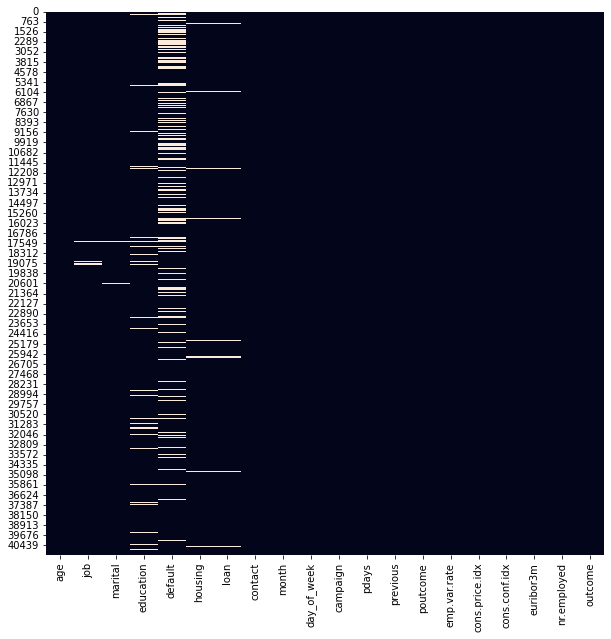

In [24]:
# missing pattern in rows.
plt.subplots(figsize=(10,10))
sns.heatmap(df_bank.isnull(), cbar=False);

### 3.5 Imputing missing values <a name="3.5"></a>
---

We adopt a combination of **frequent categorical variable imputation** and **adding a new importance column for denoting the imputed value**. We used this approach for the following reasons:

- Only six columns have null values. The 'education' column has a missing ratio greater than 20%. The rest of the columns have missing ratios below 5% or 1%. Using the most frequent variable to impute will not distort the original attribute's distribution by a lot for columns with a low missing ratio. 


- However, imputing the 'education' column this way will distort the distribution by a considerable degree and create biases for the model. To avoid increasing data dimension and misleading the model, we only add an importance column for 'education' to introduce weights for imputed values to help the model distinguish the imputed and actual values.


In [25]:
def mark_nan(df,col):
    
    df[col+"_imputed"] = df[col]
    df[col+"_imputed"].loc[~df[col+"_imputed"].isnull()] = 0
    df[col+"_imputed"].loc[df[col+"_imputed"].isnull()] = 1
    
    return df

In [26]:
df_bank = mark_nan(df_bank, "education") #run once!!!

In [27]:
def impute_value(df):
    for c in cate_cols:
        if df[c].isnull().sum() > 0:
            most_frequent = df[c].mode()[0]
            df[c].fillna(most_frequent, inplace = True)
        else:
            continue
    return df

In [28]:
df_bank = impute_value(df_bank)

### 3.6 Split train test data <a name="3.6"></a>

In [29]:
def split_XY(df):
    X = df.loc[:, df.columns != 'outcome']
    Y = df['outcome']
    return X, Y

def split_data(X,Y):
    x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size = 0.2, random_state = 42)
    return x_train, x_test, y_train, y_test

In [30]:
#engineered data 
x_eng, y_eng = split_XY(df_bank)

# one hot encoding
x_eng = pd.get_dummies(x_eng)

x_train_eng, x_test_eng, y_train_eng, y_test_eng = split_data(x_eng, y_eng)

### 3.7 Feature selection <a name="3.7"></a>
---

This dataset contains 20 columns, and 11 of them are categorical. Therefore, one potential problem is the **long execution time** and **over-fitting** brought by the high dimension of the one-hot encoded data. 

- We will use the **random forest algorithm's feature importance** to remove columns that are not contributing a lot to the prediction. For example, from the below feature importance ranking, we can see the importance for **'default_no', 'default_yes', and 'education_illiterate' is close to zero**; hence, we can drop these variables.

- To ensure the feature selection is adequate, we will compare the accuracy score obtained by predicting the original and selected data using cross-validation below.

In [31]:
#predict on orginal data using random forest model

rfc = RandomForestClassifier(random_state = 42)
rfc = rfc.fit(x_train_eng,y_train_eng)
cv_results = cross_validate(rfc, x_train_eng, y_train_eng, cv=3, scoring = ("accuracy","precision",'f1','roc_auc'))
cv_results
avg_accuracy = cv_results['test_accuracy'].mean()*100

print(f'The orginal RFC model has an avergae accuracy of {avg_accuracy:.2f}%')

The orginal RFC model has an avergae accuracy of 89.23%


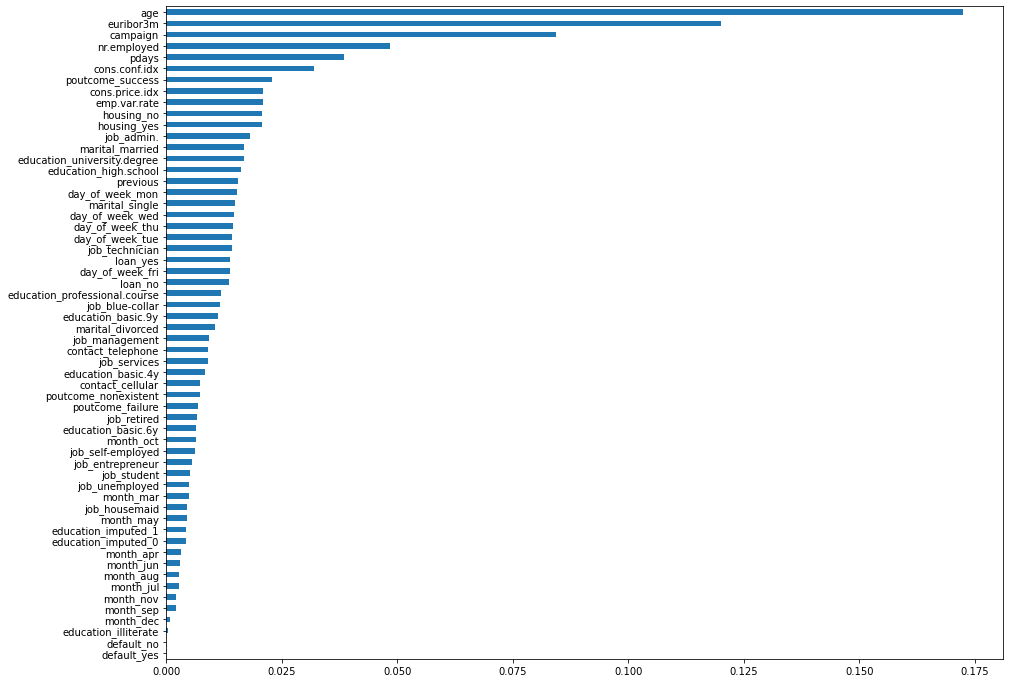

In [32]:
feat_importances = pd.Series(rfc.feature_importances_, index=x_train_eng.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh',figsize=(15,12));
plt.show();

In [33]:
# remove the low importance attributes
x_train_eng = x_train_eng.drop(columns = ['default_no', 'default_yes','education_illiterate'])
x_test_eng = x_test_eng.drop(columns = ['default_no', 'default_yes','education_illiterate'])

In [34]:
rfc = RandomForestClassifier(random_state = 42)
rfc = rfc.fit(x_train_eng,y_train_eng)
cv_results = cross_validate(rfc, x_train_eng, y_train_eng, cv=3, scoring = ("accuracy","precision",'f1','roc_auc'))
cv_results
avg_accuracy = cv_results['test_accuracy'].mean()*100

print(f'The new RFC model has an average accuracy of {avg_accuracy:.2f}%')

The new RFC model has an average accuracy of 89.28%


---
### Conclusion:

- After removing attributes that are not contributing, the accuracy is increased by 0.05%, indicating that feature selection has slightly improved the prediction accuracy.

### 3.8 Re-sampling <a name="3.8"></a>
---
From below, we can see that we have **8 times more unsuccessful outcomes than successful ones**. The imbalance in the data may result in bias in the model. 

- To fix imbalanced data, we can use sklearn's re-sample function to do over/under-sampling, SMOTE or ADASYN. Here, we will not use the first method, as it simply cuts and copies the original data, and the gap between successful and unsuccessful records ratio is too big, about 1 to 9. Up-scaling may result in **redundancy in data and overfitting** due to the lack of successful records. Down-scaling will **lose information and create biases** for the model. 


- Hence, here we will use **two ways** to re-sample the data and compare the results: 

    - SMOTE
    - ADASYN 

In [35]:
#Discover imbalance in the dataset

outcome_1 = len(df_bank[df_bank['outcome'] == 1])
outcome_0 = len(df_bank[df_bank['outcome'] == 0])

print(f'{outcome_1} of the records have Postive results, accounts for {outcome_1/len(df_bank)*100:.2f}% of the data')
print(f'{outcome_0} of the records have Negative results, accounts for {outcome_0/len(df_bank)*100:.2f}% of the data')

4640 of the records have Postive results, accounts for 11.27% of the data
36548 of the records have Negative results, accounts for 88.73% of the data


In [36]:
smote = SMOTE(sampling_strategy='not majority',random_state=42)
adasyn = ADASYN(random_state=42)

def test_sample_method(x_train_eng, y_train_eng, method):
    
    if method != "":
        x_train_eng, y_train_eng = method.fit_sample(x_train_eng, y_train_eng)
        print(f'{method}: \n \n{y_train_eng.sum()} positive outcome & {len(x_train_eng)-y_train_eng.sum()} negative outcome')
    
    
    clf = RandomForestClassifier(random_state = 42)
    clf = clf.fit(x_train_eng,y_train_eng)
    cv_results = cross_validate(clf, x_train_eng, y_train_eng, cv=3, scoring = ("accuracy","precision",'f1','roc_auc'))
    
    avg_accuracy = cv_results['test_accuracy'].mean()*100
    avg_precision = cv_results['test_precision'].mean()
    avg_roc_auc = cv_results['test_roc_auc'].mean()

    print(f'The RFC model has an average accuracy of {avg_accuracy:.2f}%')
    print(f'The RFC model has an average precision of {avg_precision:.2f}')
    print(f'The RFC model has an average roc_auc of {avg_roc_auc:.2f}')
    
    return 

In [37]:
#test orginal data performance
test_sample_method(x_train_eng, y_train_eng,"")

The RFC model has an average accuracy of 89.28%
The RFC model has an average precision of 0.54
The RFC model has an average roc_auc of 0.77


In [38]:
#test smote performance
test_sample_method(x_train_eng, y_train_eng, smote)

SMOTE(random_state=42, sampling_strategy='not majority'): 
 
29245 positive outcome & 29245 negative outcome
The RFC model has an average accuracy of 93.32%
The RFC model has an average precision of 0.95
The RFC model has an average roc_auc of 0.98


In [39]:
#test adasyn performance
test_sample_method(x_train_eng, y_train_eng, adasyn)

ADASYN(random_state=42): 
 
28477 positive outcome & 29245 negative outcome
The RFC model has an average accuracy of 92.08%
The RFC model has an average precision of 0.95
The RFC model has an average roc_auc of 0.98


---
### Conclusion:

The prediction on data **without any sampling** achieved an average accuracy of **89.28%** which is about 3% less than the prediction on re-sampled data, indicating that **re-sampling does improve the performance of our model.**


- The performances for both methods are very similar because ADASYN is based on SMOTE. However, it is expected to see SMOTE method has a slightly better performance than ADASYN because ADASYN adds some random noises to the data **for generalisation purposes**. 


- We will use **ADASYN** to re-sample the data because we focus more on the **precision score and generalisation ability** for the model than just accuracy.

# 4. Prepare data for modeling<a name="preparedata"></a>
---

### 4.1 Data transformation <a name="4.1"></a>
---

- Let's apply the cleaning and engineering functions defined above to raw data and then split the engineered data for modelling.

In [40]:
# copy the raw data and use the cleaning
df_bank = df_bank_raw.copy()
df_bank = clean_data(df_bank)
x_eng, y_eng = split_XY(df_bank)

In [41]:
# combine all the transformation above to one function

def engineer_data(df):
    
    #clear unknown labels
    df = clear_unknown(df)
    
    #mark eductaion null values
    df = mark_nan(df, "education")
    
    #impute for missing values
    df = impute_value(df)
    
    #one hot encoding
    df = pd.get_dummies(df)
    
    df = df.drop(columns = ['default_no', 'default_yes','education_illiterate'])
    
    return df

In [42]:
#apply all the data engineering function and split train and test data

x_eng = engineer_data(x_eng)
x_train, x_test, y_train, y_test = split_data(x_eng, y_eng)
x_train, y_train = adasyn.fit_sample(x_train, y_train)

In [43]:
#combine xy data for k fold validation
df_sampled_train = pd.concat([x_train, y_train], axis = 1)
df_sampled_test =  pd.concat([x_test, y_test], axis = 1)
#save processed data to csv for later use
df_sampled_train.to_csv("train_data.csv",index = False)
df_sampled_test.to_csv("test_data.csv",index = False)

### 4.2 Create a base model <a name="4.2"></a>
---

- Because the dataset is labelled and has **more than 40k** records, and we are predicting a **binary categorical output**. For base model, we choose to use the **naive bayes classification** model with **raw data** to benchmark the performance. 

In [44]:
#raw data without any engineering
x_raw, y_raw = split_XY(df_bank_raw)

# one hot encoding
x_raw = pd.get_dummies(x_raw)

#train test split
x_train_raw, x_test_raw, y_train_raw, y_test_raw = split_data(x_raw, y_raw)

#### Naive Bayes Classifer with raw data
---

In [45]:
df_base_performance = pd.DataFrame(['Accuracy', 'ROC_AUC', 'precision', 'recall', 'fbeta_score'], columns = ['metrics'])

In [46]:
#test accuracy against the original data
#clf1 uses original data

clf1 = GaussianNB()
clf1 = clf1.fit(x_train_raw,y_train_raw)
y_test_raw_pred = clf1.predict(x_test_raw)
accuracy = clf1.score(x_test_raw,y_test_raw)
roc = roc_auc_score(y_test_raw,y_test_raw_pred)
prf_scores = precision_recall_fscore_support(y_test_raw, y_test_raw_pred, average='binary', beta = 0.5)

print(f'The Naive Bayes classifier has an test accuracy of {accuracy*100:.2f}% on the raw datasets')

df_base_performance['scores_raw_data'] = [round(x,3) for x in [accuracy] + [roc] + list(prf_scores)[:3]]
df_base_performance.style.background_gradient(axis = 1)

The Naive Bayes classifier has an test accuracy of 85.08% on the raw datasets


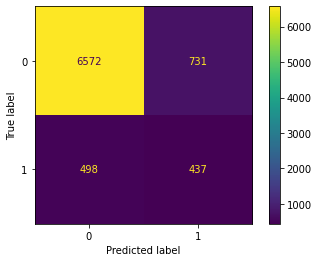

In [47]:
cm = confusion_matrix(y_test_raw, y_test_raw_pred, labels=clf1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf1.classes_)
disp.plot()
plt.show();

# 5. Model selection<a name="ms"></a>

---

**Summary of the dataset characteristic:**

- more than 40k records
- labelled
- the target variable 'outcome' is a binary categorical variable
- 11 categorical variables, 9 numerical variables
- 58 columns in the machine learning ready data

Because of the above properties, we can expect supervised classification models such **boosting algorithms** and **tree-based algorithms** to work well for this dataset. 

In [48]:
df_sampled_train = pd.read_csv("train_data.csv")
df_sampled_test = pd.read_csv("test_data.csv")
x_train_eng = df_sampled_train.loc[:, df_sampled_train.columns != 'outcome']
y_train_eng = df_sampled_train['outcome']

x_test_eng = df_sampled_test.loc[:, df_sampled_test.columns != 'outcome']
y_test_eng = df_sampled_test['outcome']

In [49]:
# list of classifiers
clf_list = [
            #averaging
            DecisionTreeClassifier(random_state = 42),
            RandomForestClassifier(random_state = 42),
            BaggingClassifier(random_state = 42),
            #boosting
            AdaBoostClassifier(random_state = 42),
            GradientBoostingClassifier(random_state = 42),
            XGBClassifier(random_state = 42, use_label_encoder=False),
            HistGradientBoostingClassifier(random_state = 42),
            #others
            KNeighborsClassifier(),
            GaussianNB()]

### 5.1 Test model performance using 5 folds <a name="5.1"></a>

In [50]:
# split the data sets into 6 folders to multple trains and tests
kf = KFold(n_splits=5,random_state=42,shuffle=True)

#create the lists of performance of each classifiers
mdl = []
fold = []
accuracy = []
fbeta = []
runtime = []
roc = []

for i,(train_index, test_index) in enumerate(kf.split(df_sampled_train)):
    
    train = df_sampled_train.iloc[train_index,:]
    test = df_sampled_train.iloc[test_index,:]
    print(f'FOLD {i+1} started')
    for clf in clf_list:
        model = clf.__class__.__name__
        
        train_input = train.loc[:, train.columns != 'outcome']
        train_output = train['outcome']
        
        valid_input = test.loc[:, test.columns != 'outcome']
        valid_output = test['outcome']

        start = time()
        clf = clf.fit(train_input,train_output) 
        pred = clf.predict(valid_input)
        end = time()
        
        accuracyScore = accuracy_score(y_true = valid_output, y_pred = pred)
        fbetaScore= fbeta_score(y_true = valid_output, y_pred = pred, beta = 0.5, average = 'binary')
        rocaucScore = roc_auc_score(valid_output, pred)
        
        fold.append(i+1)
        accuracy.append(accuracyScore)
        fbeta.append(fbetaScore)
        roc.append(rocaucScore)
        runtime.append(end-start)
        mdl.append(model)


print("ALL training done")
performance = pd.DataFrame({'Model': mdl, 'Accuracy':accuracy, 'Fbeta_0.5': fbeta, 'ROC_AUC':roc, 'Runtime': runtime, 'Fold':fold})

FOLD 1 started
[22:13:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD 2 started
[22:14:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD 3 started
[22:14:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD

### 5.2 Plot the performances in each fold <a name="5.2"></a>

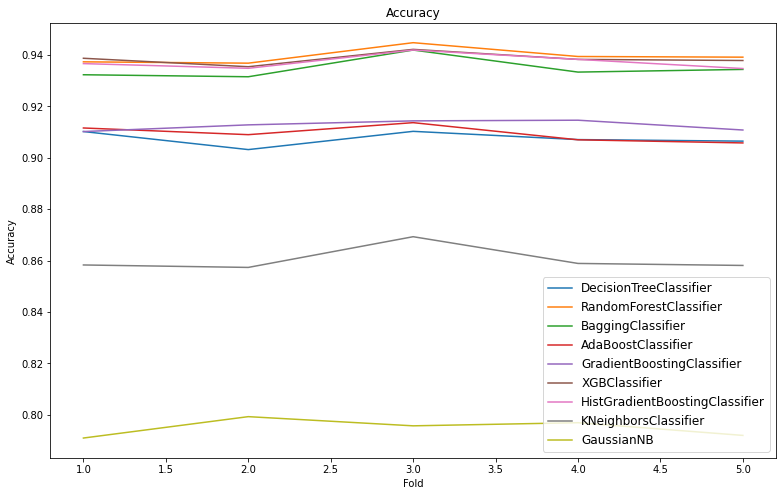

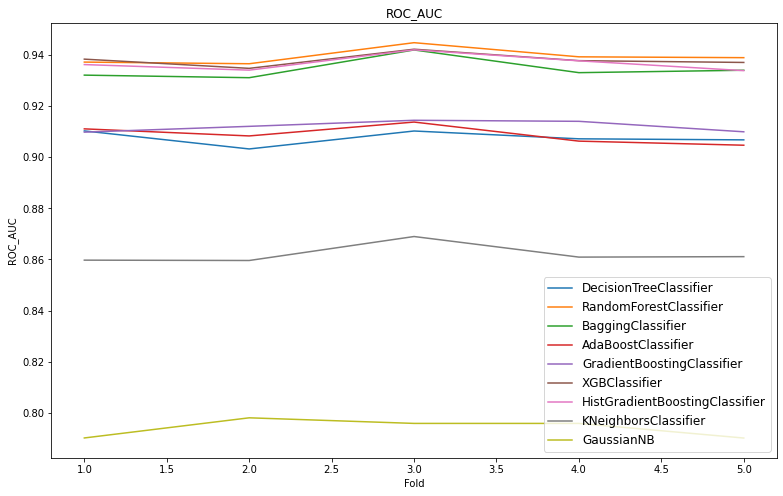

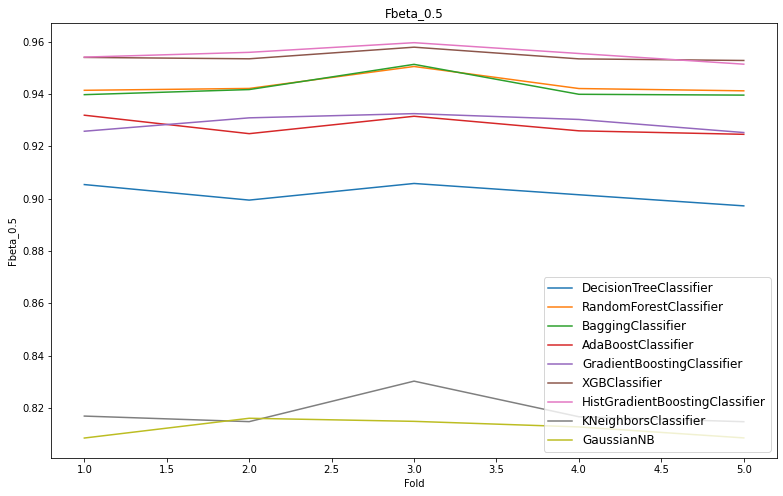

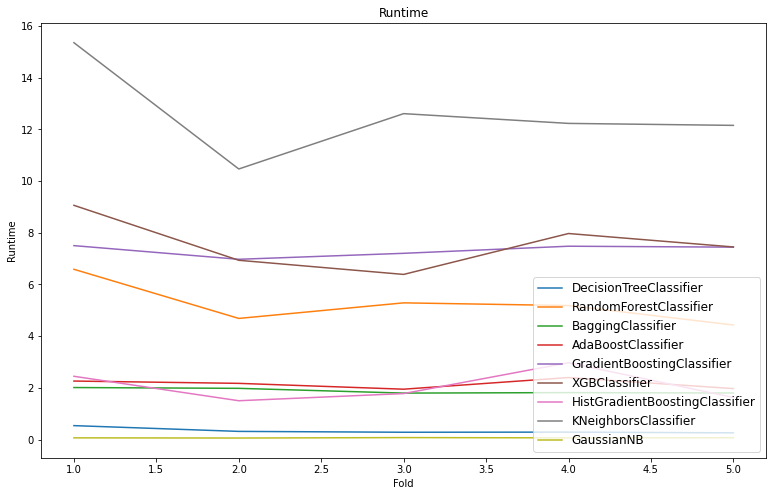

In [51]:
metric_list = ["Accuracy", "ROC_AUC", "Fbeta_0.5", "Runtime"]

for m in metric_list:
    plt.subplots(figsize=(13,8))
    sns.lineplot(x="Fold", y=m, hue = "Model", data=performance).set_title(m)
    plt.legend(loc = 'lower right', prop={'size': 12})
    plt.show();

In [52]:
# visualise performance in each metric
performance.groupby(by = ['Model']).mean().iloc[:,:-1].sort_values(by = 'Accuracy', ascending = False).style.background_gradient()

---
### Conclusion:

After sorting by accuracy, we found the **3 best models** are:

- Random Forest Classifier
- Hist Gradient Boosting Classifier
- XGB Classifier

### 5.3 Un-tunned models performance on test data <a name="5.3"></a>

In [53]:
# list of selected classifiers
new_clf_list = [
            HistGradientBoostingClassifier(random_state = 42),
            RandomForestClassifier(random_state = 42),
            XGBClassifier(random_state = 42, use_label_encoder=False)]

In [54]:
df_untunned_performance = pd.DataFrame(['Accuracy', 'ROC_AUC', 'precision', 'recall', 'fbeta_score'], columns = ['metrics'])

In [55]:
for clf in new_clf_list:
    model = clf.__class__.__name__
    clf = clf.fit(x_train_eng, y_train_eng)
    y_pred = clf.predict(x_test_eng)
    
    accuracy = clf.score(x_test_eng,y_test_eng)
    roc = roc_auc_score(y_test_eng,y_pred)
    prf_scores = precision_recall_fscore_support(y_test_eng,y_pred, average='binary', beta = 0.5)
    
    df_untunned_performance[model] = [round(x,4) for x in [accuracy] + [roc] + list(prf_scores)[:3]]
    print(f'{model} finished')

HistGradientBoostingClassifier finished
RandomForestClassifier finished
[22:16:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier finished


In [56]:
df_untunned_performance.set_index('metrics').T.sort_values(by = 'Accuracy', ascending = False).style.background_gradient()

# 6. Model tuning<a name="mt"></a>

---

- Before combining the 3 best performing models into 1 voting classifier. We need to tune each of them to their best accuracy. 

### 6.1 Random Forest Classifier <a name="6.1"></a>

In [57]:
param_grid = {'n_estimators': np.linspace(100,1000,5).astype(int),
              'criterion': ['entropy', 'gini']}

clf = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv = 3, scoring= 'accuracy')

clf = clf.fit(x_train_eng, y_train_eng)

print(clf.best_params_)
print(np.abs(clf.best_score_))

### 6.1 XGB Classifier  <a name="6.2"></a>

In [58]:
#setting grid of selected parameters for iteration
param_grid = {
              'eta': [ 0.05, 0.1, 0.15, 0.2],
              'gamma':[0, 0.2, 0.4, 0.6, 0.8, 1],
              'n_estimators': np.linspace(100,1000,5).astype(int)}

clf = GridSearchCV(XGBClassifier(random_state = 42, use_label_encoder=False), param_grid, cv = 3, scoring= 'accuracy')

clf = clf.fit(x_train_eng, y_train_eng)

print(clf.best_params_)
print(np.abs(clf.best_score_))

### 6.3 Histogram based Gradient Boosting Classifier  <a name="6.3"></a>

In [59]:
param_grid = {'max_depth':[4,6,8], 
              'max_leaf_nodes':np.arange(3,23,2), 
              'learning_rate':[0.05, 0.1, 0.15, 0.2]}

clf = GridSearchCV(HistGradientBoostingClassifier(random_state = 42), param_grid, cv = 3, scoring= 'accuracy')

clf = clf.fit(x_train_eng, y_train_eng)

print(clf.best_params_)
print(np.abs(clf.best_score_))

### 6.4 Tunned models performance on test data <a name="6.4"></a>

In [60]:
# list of selected tuned classifiers

tuned_clf_list = [
            HistGradientBoostingClassifier(learning_rate = 0.21, max_depth = 25, max_leaf_nodes = 34, random_state = 42),
            RandomForestClassifier(criterion = "entropy", n_estimators = 1000, random_state = 42),
            XGBClassifier(eta = 0.01, gamma = 0, n_estimators = 1000, random_state = 42, use_label_encoder=False)]

In [61]:
df_tunned_performance = pd.DataFrame(['Accuracy', 'ROC_AUC', 'precision', 'recall', 'fbeta_score'], columns = ['metrics'])

In [62]:
for clf in tuned_clf_list:
    model = clf.__class__.__name__
    clf = clf.fit(x_train_eng, y_train_eng)
    y_pred = clf.predict(x_test_eng)
    
    accuracy = clf.score(x_test_eng,y_test_eng)
    roc = roc_auc_score(y_test_eng,y_pred)
    prf_scores = precision_recall_fscore_support(y_test_eng,y_pred, average='binary', beta = 0.5)
    
    df_tunned_performance[model] = [round(x,4) for x in [accuracy] + [roc] + list(prf_scores)[:3]]
    print(f'{model} finished')

HistGradientBoostingClassifier finished
RandomForestClassifier finished
[22:17:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier finished


In [63]:
df_tunned_performance.set_index('metrics').T.sort_values(by = 'Accuracy', ascending = False).style.background_gradient()

# 7. Voting Classifier<a name="voting"></a>
---
- We will use voting method to combine classifiers, and use voting to balance out the weaknesses of each individual model to increase total accuracy.

- Because we already have un-tunned models and tunned models at hand. We can compare the performance of the **majority vote (hard voting)** method and the **average predicted probabilities (soft voting)** method.

### 7.1 Hard voting using un-tunned models <a name="7.1"></a>

In [73]:
df_vote_performance = pd.DataFrame(['Accuracy', 'ROC_AUC', 'precision', 'recall', 'fbeta_score'], columns = ['metrics'])

In [74]:
# list of selected classifiers
new_clf_list = [
            HistGradientBoostingClassifier(random_state = 42),
            RandomForestClassifier(random_state = 42),
            XGBClassifier(random_state = 42, use_label_encoder=False)]

vclf1 = VotingClassifier(estimators=[('rf', new_clf_list[0]), ('xgb', new_clf_list[1]), ('hgb', new_clf_list[2])], voting='hard')
vclf1 = vclf1.fit(x_train_eng, y_train_eng)
y_pred = vclf1.predict(x_test_eng)


accuracy = vclf1.score(x_test_eng,y_test_eng)
roc = roc_auc_score(y_test_eng,y_pred)
prf_scores = precision_recall_fscore_support(y_test_eng,y_pred, average='binary', beta = 0.5)

df_vote_performance['hard_vote'] = [round(x,4) for x in [accuracy] + [roc] + list(prf_scores)[:3]]

[22:25:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [75]:
df_vote_performance.style.background_gradient(axis = 1)

### 7.2 Soft voting using tunned models <a name="7.2"></a>

In [76]:
tuned_clf_list = [
            HistGradientBoostingClassifier(learning_rate = 0.21, max_depth = 25, max_leaf_nodes = 34, random_state = 42),
            RandomForestClassifier(criterion = "entropy", n_estimators = 1000, random_state = 42),
            XGBClassifier(eta = 0.01, gamma = 0, n_estimators = 1000, random_state = 42, use_label_encoder=False)]

vclf2 = VotingClassifier(estimators=[('rf', tuned_clf_list[0]), ('xgb', tuned_clf_list[1]), ('hgb', tuned_clf_list[2])], voting='soft')
vclf2 = vclf2.fit(x_train_eng, y_train_eng)
y_pred = vclf2.predict(x_test_eng)


accuracy = vclf2.score(x_test_eng,y_test_eng)
roc = roc_auc_score(y_test_eng,y_pred)
prf_scores = precision_recall_fscore_support(y_test_eng,y_pred, average='binary', beta = 0.5)

df_vote_performance['soft_vote'] = [round(x,4) for x in [accuracy] + [roc] + list(prf_scores)[:3]]

[22:26:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
df_vote_performance.style.background_gradient(axis = 1)

### 7.3 Compare final voting models' performance with base model <a name="7.3"></a>

In [78]:
pd.concat([df_base_performance,df_vote_performance.iloc[:,1:]], axis = 1).style.background_gradient(axis = 1)

# 8. Summary<a name="summary"></a>
---

- From the comparison between the base model, hard-voting model and soft-voting model, we found that **soft voting has the highest accuracy** and **hard-voting model has the highest precision score**. 

- Both voting models have out-performed the base model, **improved the accuracy by 5%** approximately and **precision score by around 0.2**. The project goal of improving accuracy and precision score is achieved.

- The voting classfiers performances are also slightly better than the tunned single models.